In [1]:
import seaborn
import lubw

In [2]:
import pandas
from io import BytesIO
import httpx
from draftudspauth import udp_auth

In [3]:
postgrest_url = (
    "https://api.udp-kn.de/postgrest-mgmt/"  # change to /postgrest/ for public endpoint
)
postgrest_auth = dict(auth=udp_auth())

In [4]:
r = httpx.get(
    postgrest_url
    + "etraw_lubw?select=entity_id,startzeit,wert",  # change to lubw/etraw_lubw? for public endpoint
    headers={
        "Accept-Profile": "postgrest_lubw",  # remove for public endpoint
        "Accept": "text/csv",
    },
    **postgrest_auth,  # remove for public endpoint
)
if r.status_code >= 400:
    display(r.text)
r.raise_for_status()
raw_data = pandas.read_csv(BytesIO(r.content))

In [5]:
long_data = raw_data.copy()
long_data["startZeit"] = pandas.to_datetime(long_data["startzeit"])
long_data["sensor"] = (
    long_data["entity_id"].astype(str).str.removeprefix("urn:raw:lubw:konstanz:")
)
del long_data["startzeit"]
del long_data["entity_id"]

wide_data = long_data.pivot_table(
    index="startZeit", columns="sensor", values="wert", aggfunc="first"
)
wide_data.index = wide_data.index.tz_convert("Europe/Berlin")

In [6]:
df = wide_data
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 155808 entries, 2008-01-01 01:00:00+01:00 to 2025-10-22 15:00:00+02:00
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   no2     151089 non-null  float64
 1   o3      148200 non-null  float64
 2   pm10    154933 non-null  float64
 3   pm25    97273 non-null   float64
dtypes: float64(4)
memory usage: 5.9 MB


In [7]:
df

sensor,no2,o3,pm10,pm25
startZeit,,,,
2008-01-01 01:00:00+01:00,38.31,0.15,239.41,NaN
2008-01-01 02:00:00+01:00,38.30,0.09,169.45,NaN
2008-01-01 03:00:00+01:00,32.03,1.09,74.82,NaN
2008-01-01 04:00:00+01:00,38.02,2.09,62.85,NaN
2008-01-01 05:00:00+01:00,23.26,21.68,37.08,NaN
...,...,...,...,...
2025-10-22 11:00:00+02:00,7.54,36.97,2.37,1.37
2025-10-22 12:00:00+02:00,7.29,40.47,1.86,1.05
2025-10-22 13:00:00+02:00,7.45,45.99,3.27,1.30


In [8]:
start_date, end_date = lubw.last_week_range()

In [9]:
lw = lubw.last_week(df)
lw

sensor,startZeit,no2,o3,pm10,pm25
0,2025-10-13 00:00:00+02:00,9.44,43.61,12.55,10.46
1,2025-10-13 01:00:00+02:00,8.61,36.31,12.34,10.43
2,2025-10-13 02:00:00+02:00,10.06,NaN,11.24,9.57
3,2025-10-13 03:00:00+02:00,10.59,28.60,11.28,9.79
4,2025-10-13 04:00:00+02:00,NaN,25.65,11.19,9.60
...,...,...,...,...,...
163,2025-10-19 19:00:00+02:00,25.03,16.70,19.98,16.07
164,2025-10-19 20:00:00+02:00,21.13,14.91,19.91,15.61
165,2025-10-19 21:00:00+02:00,22.17,14.84,18.82,15.70
166,2025-10-19 22:00:00+02:00,26.53,3.74,18.54,15.21


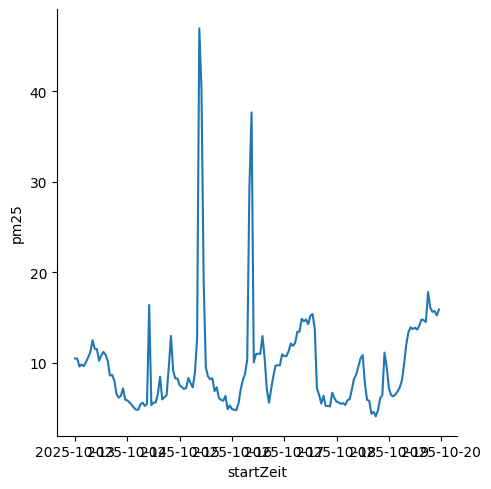

In [10]:
seaborn.relplot(
    kind="line",
    data=lw,
    x="startZeit",
    y="pm25",
)
# On the dashboard, we probably want to take an entire week, from monday to sunday. And maybe fixate it.

In [11]:
weekly = lubw.weekly_stats(df)
weekly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 929 entries, 0 to 928
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   week_start   929 non-null    object 
 1   week_ending  929 non-null    object 
 2   no2_mean     929 non-null    float64
 3   no2_median   929 non-null    float64
 4   no2_min      929 non-null    float64
 5   no2_max      929 non-null    float64
 6   o3_mean      928 non-null    float64
 7   o3_median    928 non-null    float64
 8   o3_min       928 non-null    float64
 9   o3_max       928 non-null    float64
 10  pm10_mean    928 non-null    float64
 11  pm10_median  928 non-null    float64
 12  pm10_min     928 non-null    float64
 13  pm10_max     928 non-null    float64
 14  pm25_mean    583 non-null    float64
 15  pm25_median  583 non-null    float64
 16  pm25_min     583 non-null    float64
 17  pm25_max     583 non-null    float64
dtypes: float64(16), object(2)
memory usage: 130.8+ KB


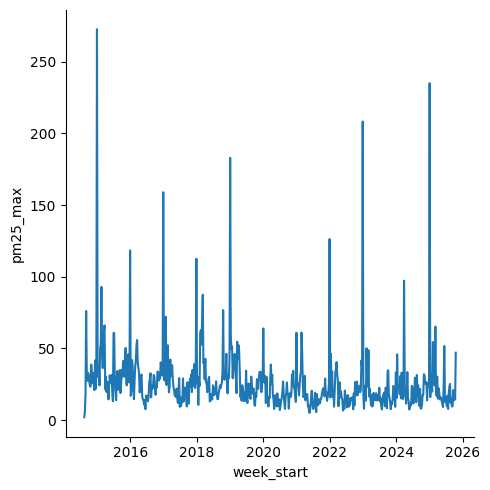

In [12]:
seaborn.relplot(
    kind="line",
    data=weekly,
    x="week_start",
    y="pm25_max",
)

In [13]:
moy = lubw.month_of_year_stats(df)
moy

,month,month_name,no2_mean,no2_median,no2_min,no2_max,o3_mean,o3_median,o3_min,o3_max,pm10_mean,pm10_median,pm10_min,pm10_max,pm25_mean,pm25_median,pm25_min,pm25_max
0,1,January,26.353926,24.54,0.21,111.62,30.488386,28.345,0.00,89.37,20.170514,16.080,0.25,745.31,13.124758,10.320,0.13,272.73
1,2,February,27.878011,25.18,0.02,119.28,35.752930,36.480,-0.55,109.21,23.395268,19.220,-0.33,132.86,15.005013,11.765,0.18,92.91
2,3,March,23.075574,19.17,0.01,110.90,49.308036,52.640,0.07,125.89,22.061821,18.360,0.32,317.78,13.982135,10.830,0.20,97.21
3,4,April,18.044682,14.89,0.02,105.34,64.209562,65.840,0.01,159.33,17.123385,14.630,0.33,107.04,9.541159,7.920,0.16,52.29
4,5,May,12.740756,10.88,0.07,107.37,70.199491,68.880,0.05,162.98,12.494185,11.010,0.68,85.04,6.835724,5.980,0.30,31.80
5,6,June,10.777320,9.29,0.08,73.99,75.229895,72.255,5.85,182.90,13.122147,11.710,0.59,80.83,7.359736,6.470,0.45,51.60
6,7,July,11.242750,9.48,0.09,85.20,74.327050,70.700,1.53,199.46,12.782241,11.140,0.61,89.71,6.937329,5.960,0.39,60.75
7,8,August,13.106608,11.11,0.11,101.46,66.872520,63.820,0.25,203.17,13.221738,11.690,0.25,158.89,7.857383,6.670,0.44,34.27
8,9,September,16.098735,13.63,0.34,89.14,48.506442,47.500,0.04,155.59,13.775305,12.240,0.14,64.91,8.615055,7.290,0.26,76.09
9,10,October,20.629881,18.84,0.35,93.16,26.823921,22.830,0.01,105.83,16.151697,14.155,-0.22,243.01,10.569792,8.960,0.17,76.70


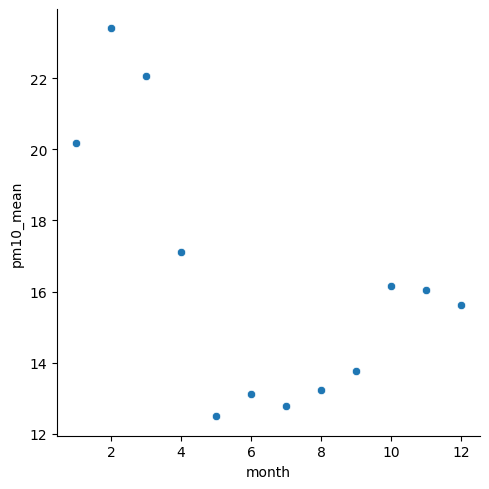

In [14]:
seaborn.relplot(
    data=moy,
    x="month",
    y="pm10_mean",
)

In [15]:
dow = lubw.day_of_week_stats(df)
dow

,day_of_week,day,no2_mean,no2_median,no2_min,no2_max,o3_mean,o3_median,o3_min,o3_max,pm10_mean,pm10_median,pm10_min,pm10_max,pm25_mean,pm25_median,pm25_min,pm25_max
0,0,Mon,18.718026,15.36,0.08,96.78,49.108003,47.875,0.02,168.58,15.093098,12.290,0.28,422.03,9.464869,7.230,0.19,112.53
1,1,Tue,19.755602,16.08,0.01,111.62,49.205799,48.230,0.00,183.73,16.297431,13.130,0.40,745.31,10.029706,7.510,0.18,183.00
2,2,Wed,20.358804,16.81,0.02,110.90,49.070147,47.605,0.01,197.09,17.177222,14.060,0.20,1323.33,10.344552,8.040,0.13,235.12
3,3,Thu,20.652954,16.94,0.09,135.26,48.557331,46.885,0.01,182.04,17.412181,14.185,0.29,646.15,10.386749,8.180,0.24,272.73
4,4,Fri,20.436448,16.86,0.02,119.28,49.095050,47.300,-0.55,203.17,17.069606,14.170,0.27,432.45,10.724568,8.415,0.15,118.36
5,5,Sat,18.137605,14.72,0.01,104.85,50.313186,49.360,0.01,180.16,16.195541,13.280,-0.33,187.35,10.684379,8.520,0.16,126.23
6,6,Son,15.475097,12.14,0.04,89.78,51.775282,51.460,0.01,180.28,14.872087,12.080,-0.25,246.56,9.922075,7.520,0.15,208.31


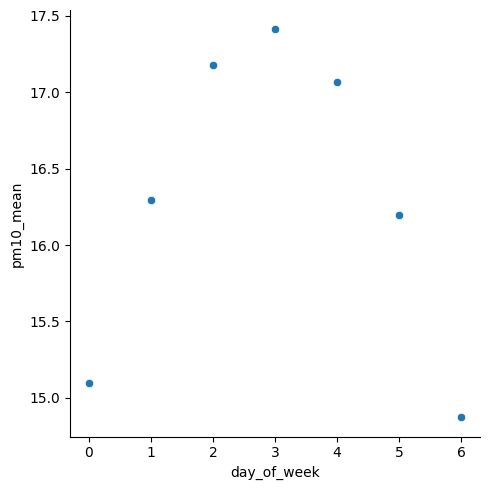

In [16]:
seaborn.relplot(
    data=dow,
    x="day_of_week",
    y="pm10_mean",
)

In [17]:
hod = lubw.hour_of_day_stats(df)
hod.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   hour_of_day  24 non-null     int32  
 1   no2_mean     24 non-null     float64
 2   no2_median   24 non-null     float64
 3   no2_min      24 non-null     float64
 4   no2_max      24 non-null     float64
 5   o3_mean      24 non-null     float64
 6   o3_median    24 non-null     float64
 7   o3_min       24 non-null     float64
 8   o3_max       24 non-null     float64
 9   pm10_mean    24 non-null     float64
 10  pm10_median  24 non-null     float64
 11  pm10_min     24 non-null     float64
 12  pm10_max     24 non-null     float64
 13  pm25_mean    24 non-null     float64
 14  pm25_median  24 non-null     float64
 15  pm25_min     24 non-null     float64
 16  pm25_max     24 non-null     float64
dtypes: float64(16), int32(1)
memory usage: 3.2 KB


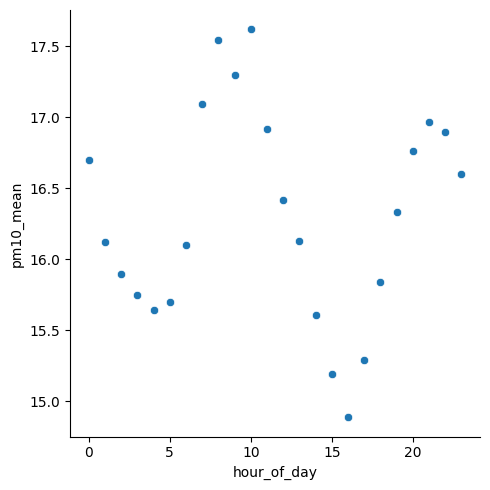

In [18]:
seaborn.relplot(
    data=hod,
    x="hour_of_day",
    y="pm10_mean",
)